In [6]:
# Import Dependencies
%matplotlib inline

# Begin Python Imports
import datetime, warnings, scipy
warnings.filterwarnings("ignore")

# Data Manipulation
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)

# Visualization 
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn-v0_8-whitegrid')

In [7]:
# Read 2018 airport data 
flight_data = pd.read_csv('flights.csv')

# Check first 2 instances and last 2 instances
result = pd.concat([flight_data.head(2), flight_data.tail(2)])

In [10]:
print(result)

            FL_DATE                 AIRLINE                 AIRLINE_DOT  \
0        2019-01-09   United Air Lines Inc.   United Air Lines Inc.: UA   
1        2022-11-19    Delta Air Lines Inc.    Delta Air Lines Inc.: DL   
2999998  2019-11-13        Republic Airline        Republic Airline: YX   
2999999  2019-06-15  Southwest Airlines Co.  Southwest Airlines Co.: WN   

        AIRLINE_CODE  DOT_CODE  FL_NUMBER ORIGIN          ORIGIN_CITY DEST  \
0                 UA     19977       1562    FLL  Fort Lauderdale, FL  EWR   
1                 DL     19790       1149    MSP      Minneapolis, MN  SEA   
2999998           YX     20452       6134    BOS           Boston, MA  LGA   
2999999           WN     19393       2823    LGB       Long Beach, CA  SJC   

            DEST_CITY  CRS_DEP_TIME  DEP_TIME  DEP_DELAY  TAXI_OUT  \
0          Newark, NJ          1155    1151.0       -4.0      19.0   
1         Seattle, WA          2120    2114.0       -6.0       9.0   
2999998  New York, NY  

In [11]:
# Check dimension of dataset
flight_data.shape
print("There are "+ str(flight_data.shape[0]) +" rows and "+ str(flight_data.shape[1]) +" columns from the flight dataset.")

There are 3000000 rows and 32 columns from the flight dataset.


In [12]:
# Convert flight_data column to datetime format
flight_data['FL_DATE'] =  pd.to_datetime(flight_data['FL_DATE'], format='%Y-%m-%d')

In [13]:
# Check column type
flight_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000000 entries, 0 to 2999999
Data columns (total 32 columns):
 #   Column                   Dtype         
---  ------                   -----         
 0   FL_DATE                  datetime64[ns]
 1   AIRLINE                  object        
 2   AIRLINE_DOT              object        
 3   AIRLINE_CODE             object        
 4   DOT_CODE                 int64         
 5   FL_NUMBER                int64         
 6   ORIGIN                   object        
 7   ORIGIN_CITY              object        
 8   DEST                     object        
 9   DEST_CITY                object        
 10  CRS_DEP_TIME             int64         
 11  DEP_TIME                 float64       
 12  DEP_DELAY                float64       
 13  TAXI_OUT                 float64       
 14  WHEELS_OFF               float64       
 15  WHEELS_ON                float64       
 16  TAXI_IN                  float64       
 17  CRS_ARR_TIME             in

In [14]:
# Calculate the proportion of missing data

def checkMissing(data,perc=0):
    """ 
    Takes in a dataframe and returns
    the percentage of missing value.
    """
    missing = [(i, data[i].isna().mean()*100) for i in data]
    missing = pd.DataFrame(missing, columns=["column_name", "percentage"])
    missing = missing[missing.percentage > perc]
    print(missing.sort_values("percentage", ascending=False).reset_index(drop=True))

print("Proportion of missing data in columns")
checkMissing(flight_data)

Proportion of missing data in columns
                column_name  percentage
0         CANCELLATION_CODE   97.362000
1         DELAY_DUE_CARRIER   82.204567
2        DELAY_DUE_SECURITY   82.204567
3             DELAY_DUE_NAS   82.204567
4         DELAY_DUE_WEATHER   82.204567
5   DELAY_DUE_LATE_AIRCRAFT   82.204567
6                 ARR_DELAY    2.873267
7              ELAPSED_TIME    2.873267
8                  AIR_TIME    2.873267
9                   TAXI_IN    2.664800
10                WHEELS_ON    2.664800
11                 ARR_TIME    2.664733
12               WHEELS_OFF    2.626867
13                 TAXI_OUT    2.626867
14                DEP_DELAY    2.588133
15                 DEP_TIME    2.587167
16         CRS_ELAPSED_TIME    0.000467


These columns are dropped: 
CANCELLATION_CODE, 
DELAY_DUE_CARRIER, 
DELAY_DUE_SECURITY, 
DELAY_DUE_NAS, 
DELAY_DUE_WEATHER, 
DELAY_DUE_LATE_AIRCRAFT.

from the dataframe as these columns had more than 50% of missing values which does not provide any useful information to our analysis. Since our main objective is to predict flight delay.

In [ ]:
#Fill the missing value 0
flight_data['DELAY_DUE_LATE_AIRCRAFT']=flight_data['DELAY_DUE_LATE_AIRCRAFT'].fillna(0)
flight_data['DELAY_DUE_CARRIER']=flight_data[''].fillna(0)
flight_data['DELAY_DUE_WEATHER']=flight_data['DELAY_DUE_WEATHER'].fillna(0)
flight_data['DELAY_DUE_NAS']=flight_data['DELAY_DUE_NAS'].fillna(0)
flight_data['DELAY_DUE_SECURITY']=flight_data['DELAY_DUE_SECURITY'].fillna(0)

In [15]:
# Function that convert the 'HHMM' string to datetime.time
def format_heure(chaine):
    if pd.isnull(chaine):
        return np.nan
    else:
        if chaine == 2400: chaine = 0
        chaine = "{0:04d}".format(int(chaine))
        heure = datetime.time(int(chaine[0:2]), int(chaine[2:4]))
        return heure
        # return pd.to_datetime(heure, format='%H:%M:%S')
    
    # pd.to_datetime(heure, format='%Y-%m-%d')

In [16]:
flight_data['DEP_TIME'] = flight_data['DEP_TIME'].apply(format_heure)
flight_data['CRS_DEP_TIME'] = flight_data['CRS_DEP_TIME'].apply(format_heure)

flight_data['ARR_TIME'] = flight_data['ARR_TIME'].apply(format_heure) 
flight_data['CRS_ARR_TIME'] = flight_data['CRS_ARR_TIME'].apply(format_heure)

flight_data['WHEELS_OFF'] = flight_data['WHEELS_OFF'].apply(format_heure)
flight_data['WHEELS_ON'] = flight_data['WHEELS_ON'].apply(format_heure)

In [17]:
def time_difference(actual,plan):
    actual_time = pd.to_timedelta(actual.astype(str)) 
    plan_time = pd.to_timedelta(plan.astype(str))
    return actual_time.sub(plan_time).dt.total_seconds().div(60)

flight_data['WHEELS_OFF_elapse'] =  time_difference(flight_data['WHEELS_OFF'],flight_data['DEP_TIME'])
flight_data['WHEELS_ON_elapse'] =  time_difference(flight_data['ARR_TIME'] ,flight_data['WHEELS_ON'])

# Remove incorrect record
flight_data=flight_data[flight_data['WHEELS_OFF_elapse']>0]
flight_data=flight_data[flight_data['WHEELS_ON_elapse']>0]

In [10]:
# Check first 2 instances and last 2 instances
pd.concat([flight_data.head(2), flight_data.tail(2)])

,FL_DATE,AIRLINE,AIRLINE_DOT,AIRLINE_CODE,DOT_CODE,FL_NUMBER,ORIGIN,ORIGIN_CITY,DEST,DEST_CITY,DEP_DELAY,TAXI_OUT,TAXI_IN,ARR_DELAY,DIVERTED,CRS_ELAPSED_TIME,ELAPSED_TIME,AIR_TIME,DISTANCE,DELAY_DUE_CARRIER,DELAY_DUE_WEATHER,DELAY_DUE_NAS,DELAY_DUE_SECURITY,DELAY_DUE_LATE_AIRCRAFT
0,2019-01-09,United Air Lines Inc.,United Air Lines Inc.: UA,UA,19977,1562,FLL,"Fort Lauderdale, FL",EWR,"Newark, NJ",-4.0,19.0,4.0,-14.0,0.0,186.0,176.0,153.0,1065.0,NaN,NaN,NaN,NaN,NaN
1,2022-11-19,Delta Air Lines Inc.,Delta Air Lines Inc.: DL,DL,19790,1149,MSP,"Minneapolis, MN",SEA,"Seattle, WA",-6.0,9.0,38.0,-5.0,0.0,235.0,236.0,189.0,1399.0,NaN,NaN,NaN,NaN,NaN
2999998,2019-11-13,Republic Airline,Republic Airline: YX,YX,20452,6134,BOS,"Boston, MA",LGA,"New York, NY",-5.0,19.0,8.0,-16.0,0.0,88.0,77.0,50.0,184.0,NaN,NaN,NaN,NaN,NaN
2999999,2019-06-15,Southwest Airlines Co.,Southwest Airlines Co.: WN,WN,19393,2823,LGB,"Long Beach, CA",SJC,"San Jose, CA",-3.0,9.0,2.0,-10.0,0.0,70.0,63.0,52.0,324.0,NaN,NaN,NaN,NaN,NaN


In [11]:
# Check column type
flight_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000000 entries, 0 to 2999999
Data columns (total 24 columns):
 #   Column                   Dtype  
---  ------                   -----  
 0   FL_DATE                  object 
 1   AIRLINE                  object 
 2   AIRLINE_DOT              object 
 3   AIRLINE_CODE             object 
 4   DOT_CODE                 int64  
 5   FL_NUMBER                int64  
 6   ORIGIN                   object 
 7   ORIGIN_CITY              object 
 8   DEST                     object 
 9   DEST_CITY                object 
 10  DEP_DELAY                float64
 11  TAXI_OUT                 float64
 12  TAXI_IN                  float64
 13  ARR_DELAY                float64
 14  DIVERTED                 float64
 15  CRS_ELAPSED_TIME         float64
 16  ELAPSED_TIME             float64
 17  AIR_TIME                 float64
 18  DISTANCE                 float64
 19  DELAY_DUE_CARRIER        float64
 20  DELAY_DUE_WEATHER        float64
 21  DELAY_DU

In [19]:
columns_to_drop = [
    'CANCELLATION_CODE', 'CANCELLED', 'DOT_CODE', 'FL_NUMBER','AIRLINE','AIRLINE_DOT','ORIGIN_CITY',
    'CRS_DEP_TIME', 'DEP_TIME', 'CRS_ARR_TIME', 'ARR_TIME',
    'WHEELS_ON', 'WHEELS_OFF'
]

existing_columns_to_drop = [col for col in columns_to_drop if col in flight_data.columns]
flight_data.drop(existing_columns_to_drop, axis=1, inplace=True)

In [20]:
#Check number of missing values
flight_data.isna().sum()

FL_DATE                    0
AIRLINE_CODE               0
ORIGIN                     0
DEST                       0
DEST_CITY                  0
DEP_DELAY                  0
TAXI_OUT                   0
TAXI_IN                    0
ARR_DELAY                  0
DIVERTED                   0
CRS_ELAPSED_TIME           0
ELAPSED_TIME               0
AIR_TIME                   0
DISTANCE                   0
DELAY_DUE_CARRIER          0
DELAY_DUE_WEATHER          0
DELAY_DUE_NAS              0
DELAY_DUE_SECURITY         0
DELAY_DUE_LATE_AIRCRAFT    0
dtype: int64

In [18]:
flight_data = flight_data.dropna()

In [21]:
#Check number of missing values
flight_data.isna().sum()

FL_DATE                    0
AIRLINE_CODE               0
ORIGIN                     0
DEST                       0
DEST_CITY                  0
DEP_DELAY                  0
TAXI_OUT                   0
TAXI_IN                    0
ARR_DELAY                  0
DIVERTED                   0
CRS_ELAPSED_TIME           0
ELAPSED_TIME               0
AIR_TIME                   0
DISTANCE                   0
DELAY_DUE_CARRIER          0
DELAY_DUE_WEATHER          0
DELAY_DUE_NAS              0
DELAY_DUE_SECURITY         0
DELAY_DUE_LATE_AIRCRAFT    0
dtype: int64

In [22]:
# Check the instances for OP_CARRIER
flight_data.AIRLINE_CODE.unique()

array(['DL', 'WN', 'YX', 'UA', 'G4', 'B6', 'AS', 'MQ', 'NK', 'AA', 'OO',
       '9E', 'OH', 'YV', 'HA', 'QX', 'EV', 'F9'], dtype=object)

In [23]:
flight_data['AIRLINE_CODE'].replace({
    'UA':'United Airlines',
    'AS':'Alaska Airlines',
    '9E':'Endeavor Air',
    'B6':'JetBlue Airways',
    'EV':'ExpressJet',
    'F9':'Frontier Airlines',
    'G4':'Allegiant Air',
    'HA':'Hawaiian Airlines',
    'MQ':'Envoy Air',
    'NK':'Spirit Airlines',
    'OH':'PSA Airlines',
    'OO':'SkyWest Airlines',
    'VX':'Virgin America',
    'WN':'Southwest Airlines',
    'YV':'Mesa Airline',
    'YX':'Republic Airways',
    'AA':'American Airlines',
    'DL':'Delta Airlines'
}, inplace=True)

In [24]:
flight_data.AIRLINE_CODE.nunique()


18

In [25]:
flight_data.AIRLINE_CODE.value_counts()

AIRLINE_CODE
Southwest Airlines    107275
American Airlines      73864
Delta Airlines         55964
SkyWest Airlines       53222
United Airlines        47559
JetBlue Airways        29553
Republic Airways       21830
Spirit Airlines        20615
Envoy Air              20406
PSA Airlines           17956
Alaska Airlines        17870
Frontier Airlines      16712
Endeavor Air           14324
Allegiant Air          13091
Mesa Airline           11637
Hawaiian Airlines       5192
ExpressJet              3856
QX                      2937
Name: count, dtype: int64

In [26]:
top_cities = flight_data.DEST.value_counts().iloc[0:1].rename_axis('DEST').reset_index(name='TOTAL_FLIGHTS')
top_cities.head()

,DEST,TOTAL_FLIGHTS
0,DFW,24081


In [28]:
# Checking the cities within the numpy array just to verify that it worked
top_cities.DEST.unique()

# Creating a list with top cities only:
city_list = top_cities['DEST'].tolist()

In [29]:
boolean_series =  flight_data.DEST.isin(city_list)
flight_data =  flight_data[boolean_series]
flight_data.head()

,FL_DATE,AIRLINE_CODE,ORIGIN,DEST,DEST_CITY,DEP_DELAY,TAXI_OUT,TAXI_IN,ARR_DELAY,DIVERTED,CRS_ELAPSED_TIME,ELAPSED_TIME,AIR_TIME,DISTANCE,DELAY_DUE_CARRIER,DELAY_DUE_WEATHER,DELAY_DUE_NAS,DELAY_DUE_SECURITY,DELAY_DUE_LATE_AIRCRAFT
79,2020-03-17,Envoy Air,GRK,DFW,"Dallas/Fort Worth, TX",52.0,32.0,20.0,85.0,0.0,59.0,92.0,40.0,134.0,0.0,0.0,33.0,0.0,52.0
389,2022-12-19,JetBlue Airways,BOS,DFW,"Dallas/Fort Worth, TX",26.0,18.0,10.0,26.0,0.0,274.0,274.0,246.0,1562.0,22.0,0.0,0.0,0.0,4.0
575,2021-04-28,Envoy Air,SPS,DFW,"Dallas/Fort Worth, TX",24.0,19.0,11.0,63.0,0.0,63.0,102.0,72.0,113.0,0.0,0.0,39.0,0.0,24.0
598,2020-09-29,PSA Airlines,BHM,DFW,"Dallas/Fort Worth, TX",43.0,10.0,9.0,33.0,0.0,118.0,108.0,89.0,597.0,33.0,0.0,0.0,0.0,0.0
610,2021-04-16,Delta Airlines,ATL,DFW,"Dallas/Fort Worth, TX",35.0,25.0,6.0,50.0,0.0,143.0,158.0,127.0,731.0,0.0,0.0,15.0,0.0,35.0


In [30]:
flight_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 24081 entries, 79 to 2999982
Data columns (total 19 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   FL_DATE                  24081 non-null  object 
 1   AIRLINE_CODE             24081 non-null  object 
 2   ORIGIN                   24081 non-null  object 
 3   DEST                     24081 non-null  object 
 4   DEST_CITY                24081 non-null  object 
 5   DEP_DELAY                24081 non-null  float64
 6   TAXI_OUT                 24081 non-null  float64
 7   TAXI_IN                  24081 non-null  float64
 8   ARR_DELAY                24081 non-null  float64
 9   DIVERTED                 24081 non-null  float64
 10  CRS_ELAPSED_TIME         24081 non-null  float64
 11  ELAPSED_TIME             24081 non-null  float64
 12  AIR_TIME                 24081 non-null  float64
 13  DISTANCE                 24081 non-null  float64
 14  DELAY_DUE_CARRIER       

In [31]:
import calendar
flight_date=pd.DatetimeIndex(flight_data['FL_DATE'])

flight_data['DAY'] = flight_date.day
flight_data['MONTH'] = flight_date.month
flight_data['MONTH_AB'] = flight_data['MONTH'].apply(lambda x: calendar.month_abbr[x])
flight_data['DAYOFWEEK'] = flight_date.dayofweek
flight_data['DAYNAME'] = flight_data['DAYOFWEEK'].apply(lambda x: calendar.day_name[x])

# 1 Weekday, 0 Weekend
daytype = []
for value in flight_data['DAYOFWEEK']:
    if value in (0,1,2,3,4):
        daytype.append(1) #weekday
    else:
        daytype.append(0) #weekend
flight_data['WEEKDAY'] = daytype
flight_data.head(2)

,FL_DATE,AIRLINE_CODE,ORIGIN,DEST,DEST_CITY,DEP_DELAY,TAXI_OUT,TAXI_IN,ARR_DELAY,DIVERTED,CRS_ELAPSED_TIME,ELAPSED_TIME,AIR_TIME,DISTANCE,DELAY_DUE_CARRIER,DELAY_DUE_WEATHER,DELAY_DUE_NAS,DELAY_DUE_SECURITY,DELAY_DUE_LATE_AIRCRAFT,DAY,MONTH,MONTH_AB,DAYOFWEEK,DAYNAME,WEEKDAY
79,2020-03-17,Envoy Air,GRK,DFW,"Dallas/Fort Worth, TX",52.0,32.0,20.0,85.0,0.0,59.0,92.0,40.0,134.0,0.0,0.0,33.0,0.0,52.0,17,3,Mar,1,Tuesday,1
389,2022-12-19,JetBlue Airways,BOS,DFW,"Dallas/Fort Worth, TX",26.0,18.0,10.0,26.0,0.0,274.0,274.0,246.0,1562.0,22.0,0.0,0.0,0.0,4.0,19,12,Dec,0,Monday,1


In [32]:
# For checking
print('Maximum number of days in a month:', flight_data.DAY.nunique())
print('Total number of months:', flight_data.MONTH.nunique())
print('Total number of days per week:', flight_data.DAYNAME.nunique())

print()

print('Months present in dataframe:',flight_data.MONTH.unique())
print('Months present in dataframe:', flight_data.MONTH_AB.unique())

print()
print('Days present in dataframe:', flight_data['DAYOFWEEK'].unique())
print('Days present in dataframe:', flight_data.DAYNAME.unique())


Maximum number of days in a month: 31
Total number of months: 12
Total number of days per week: 7

Months present in dataframe: [ 3 12  4  9  5  6  7 10  1  8  2 11]
Months present in dataframe: ['Mar' 'Dec' 'Apr' 'Sep' 'May' 'Jun' 'Jul' 'Oct' 'Jan' 'Aug' 'Feb' 'Nov']

Days present in dataframe: [1 0 2 4 6 3 5]
Days present in dataframe: ['Tuesday' 'Monday' 'Wednesday' 'Friday' 'Sunday' 'Thursday' 'Saturday']


In [33]:
airports = pd.read_csv('airports.csv')
airports.head(10)

,IATA_CODE,AIRPORT,CITY,STATE,COUNTRY,LATITUDE,LONGITUDE
0,ABE,Lehigh Valley International Airport,Allentown,PA,USA,40.65236,-75.44040
1,ABI,Abilene Regional Airport,Abilene,TX,USA,32.41132,-99.68190
2,ABQ,Albuquerque International Sunport,Albuquerque,NM,USA,35.04022,-106.60919
3,ABR,Aberdeen Regional Airport,Aberdeen,SD,USA,45.44906,-98.42183
4,ABY,Southwest Georgia Regional Airport,Albany,GA,USA,31.53552,-84.19447
5,ACK,Nantucket Memorial Airport,Nantucket,MA,USA,41.25305,-70.06018
6,ACT,Waco Regional Airport,Waco,TX,USA,31.61129,-97.23052
7,ACV,Arcata Airport,Arcata/Eureka,CA,USA,40.97812,-124.10862
8,ACY,Atlantic City International Airport,Atlantic City,NJ,USA,39.45758,-74.57717
9,ADK,Adak Airport,Adak,AK,USA,51.87796,-176.64603


In [34]:
# Check dimension of dataset
airports.shape
print("There are "+ str(airports.shape[0]) +" rows and "+ str(airports.shape[1]) +" columns from the airport dataset.")

There are 322 rows and 7 columns from the airport dataset.


In [35]:
print("There are "+str(len(airports.IATA_CODE.unique()))+" records")

There are 322 records


In [36]:
# Covert to list
airport_IATA_CODE = list(airports['IATA_CODE'])

In [37]:
flight_data.ORIGIN.unique()

array(['GRK', 'BOS', 'SPS', 'BHM', 'ATL', 'SEA', 'ABQ', 'LGA', 'DTW',
       'MOB', 'CAE', 'MSP', 'XNA', 'BRO', 'CLE', 'PHL', 'ORD', 'BWI',
       'BUR', 'IAH', 'COU', 'MFE', 'JFK', 'MSN', 'OKC', 'BTR', 'VPS',
       'FLL', 'AUS', 'CRP', 'SRQ', 'GNV', 'GEG', 'SNA', 'EWR', 'GSP',
       'PNS', 'CHS', 'LAX', 'ELP', 'ECP', 'PIB', 'RDU', 'MIA', 'ASE',
       'ICT', 'SLC', 'HOU', 'MEM', 'GSO', 'MCI', 'ONT', 'BUF', 'SAF',
       'HSV', 'GCK', 'FSD', 'MTJ', 'GGG', 'TYS', 'RAP', 'SAT', 'MCO',
       'COS', 'DCA', 'RSW', 'AMA', 'FLG', 'ACT', 'LBB', 'BFL', 'MLU',
       'MSY', 'SGF', 'BNA', 'CMH', 'DAY', 'CLL', 'STS', 'OMA', 'JAX',
       'SHV', 'CLT', 'TUL', 'LIT', 'JAC', 'PIT', 'DRO', 'LEX', 'LAS',
       'SFO', 'SDF', 'SWO', 'TYR', 'CMI', 'ABI', 'AGS', 'FSM', 'EGE',
       'AEX', 'SAN', 'TUS', 'BPT', 'DEN', 'CID', 'RNO', 'LRD', 'FAY',
       'SBP', 'LFT', 'STL', 'GRI', 'SPI', 'LGB', 'DRT', 'TVC', 'TPA',
       'BIS', 'CVG', 'IND', 'PHX', 'MDW', 'OGG', 'SBA', 'LAW', 'PDX',
       'DSM', 'MHK',

In [38]:
# Get the list of origin and destination from `flight_data` 
flight_ORIGIN = flight_data.ORIGIN.unique().tolist()
flight_DEST = flight_data.DEST.unique().tolist()

# Check type
print("Type:")
print(type(flight_ORIGIN))
print(type(flight_DEST))
print()
print("Length:")
print("Origin: "+str(len(flight_ORIGIN)))
print("Destination: "+str(len(flight_DEST)))

Type:
<class 'list'>
<class 'list'>

Length:
Origin: 195
Destination: 1


In [39]:
difference = [item for item in flight_ORIGIN if item not in airport_IATA_CODE]
print("IATA Code (Origin) that is not found from the airport data:")
print(difference)
print()
print("There are "+str(len(difference)))

IATA Code (Origin) that is not found from the airport data:
['STS', 'SWO', 'DRT', 'CYS', 'BKG', 'HHH']

There are 6


In [40]:
difference_2 = [item for item in flight_DEST if item not in airport_IATA_CODE]
print("IATA Code (Destination) that is not found from airport data:")
print(difference_2)
print()

IATA Code (Destination) that is not found from airport data:
[]



In [41]:
# Creating a dictionary and looking at its type for QC purposes
airport_dict = pd.Series(airports.AIRPORT.values, index=airports.IATA_CODE).to_dict()
print(type(airport_dict))

<class 'dict'>


In [42]:
flight_data['ORIGIN'].replace(airport_dict, inplace=True)
flight_data['DEST'].replace(airport_dict, inplace=True)
flight_data.head()

,FL_DATE,AIRLINE_CODE,ORIGIN,DEST,DEST_CITY,DEP_DELAY,TAXI_OUT,TAXI_IN,ARR_DELAY,DIVERTED,CRS_ELAPSED_TIME,ELAPSED_TIME,AIR_TIME,DISTANCE,DELAY_DUE_CARRIER,DELAY_DUE_WEATHER,DELAY_DUE_NAS,DELAY_DUE_SECURITY,DELAY_DUE_LATE_AIRCRAFT,DAY,MONTH,MONTH_AB,DAYOFWEEK,DAYNAME,WEEKDAY
79,2020-03-17,Envoy Air,Killeen-Fort Hood Regional Airport,Dallas/Fort Worth International Airport,"Dallas/Fort Worth, TX",52.0,32.0,20.0,85.0,0.0,59.0,92.0,40.0,134.0,0.0,0.0,33.0,0.0,52.0,17,3,Mar,1,Tuesday,1
389,2022-12-19,JetBlue Airways,Gen. Edward Lawrence Logan International Airport,Dallas/Fort Worth International Airport,"Dallas/Fort Worth, TX",26.0,18.0,10.0,26.0,0.0,274.0,274.0,246.0,1562.0,22.0,0.0,0.0,0.0,4.0,19,12,Dec,0,Monday,1
575,2021-04-28,Envoy Air,Wichita Falls Municipal Airport/Sheppard AFB,Dallas/Fort Worth International Airport,"Dallas/Fort Worth, TX",24.0,19.0,11.0,63.0,0.0,63.0,102.0,72.0,113.0,0.0,0.0,39.0,0.0,24.0,28,4,Apr,2,Wednesday,1
598,2020-09-29,PSA Airlines,Birmingham-Shuttlesworth International Airport,Dallas/Fort Worth International Airport,"Dallas/Fort Worth, TX",43.0,10.0,9.0,33.0,0.0,118.0,108.0,89.0,597.0,33.0,0.0,0.0,0.0,0.0,29,9,Sep,1,Tuesday,1
610,2021-04-16,Delta Airlines,Hartsfield-Jackson Atlanta International Airport,Dallas/Fort Worth International Airport,"Dallas/Fort Worth, TX",35.0,25.0,6.0,50.0,0.0,143.0,158.0,127.0,731.0,0.0,0.0,15.0,0.0,35.0,16,4,Apr,4,Friday,1


In [43]:
status = []

for value in flight_data['ARR_DELAY']:
    if value <= 15:
        status.append(0)
    else:
        status.append(1)
flight_data['FLIGHT_STATUS'] = status

In [44]:
flight_category = flight_data.select_dtypes(include=['object','category'])
flight_numerical = flight_data.select_dtypes(exclude=['object'])

[Text(0.5, 0, 'Number of counts')]

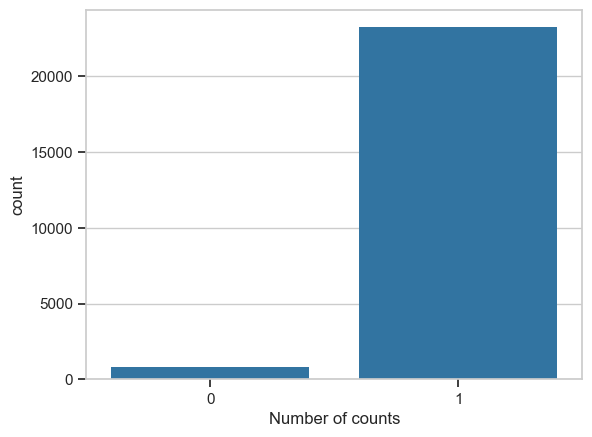

In [45]:
# Output Barplot showing the occurence of flight outcome

sns.set_context("notebook")
g=sns.countplot(x="FLIGHT_STATUS",data=flight_data)
g.set(xlabel="Number of counts")

[Text(0.5, 0, 'Number of counts')]

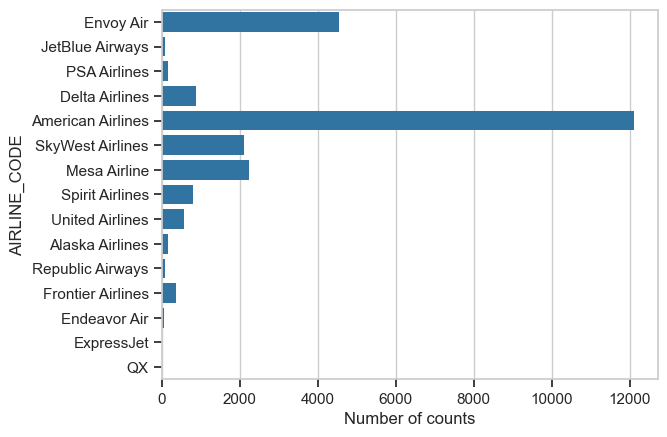

In [46]:
# Output Barplot showing the occurence of each categorical features         

sns.set_context("notebook")
g=sns.countplot(y="AIRLINE_CODE",data=flight_category)
g.set(xlabel="Number of counts")

[Text(0.5, 0, 'Number of counts')]

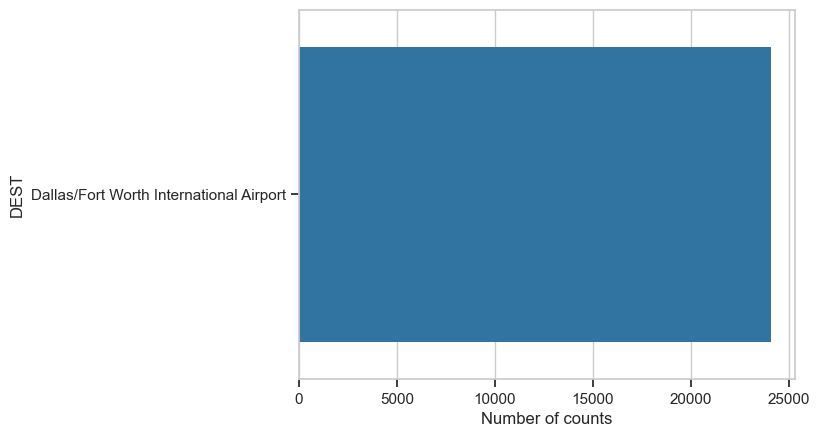

In [47]:
# Output Barplot showing the occurence of each categorical features         

sns.set_context("notebook")
g=sns.countplot(y="DEST",data=flight_category)
g.set(xlabel="Number of counts")

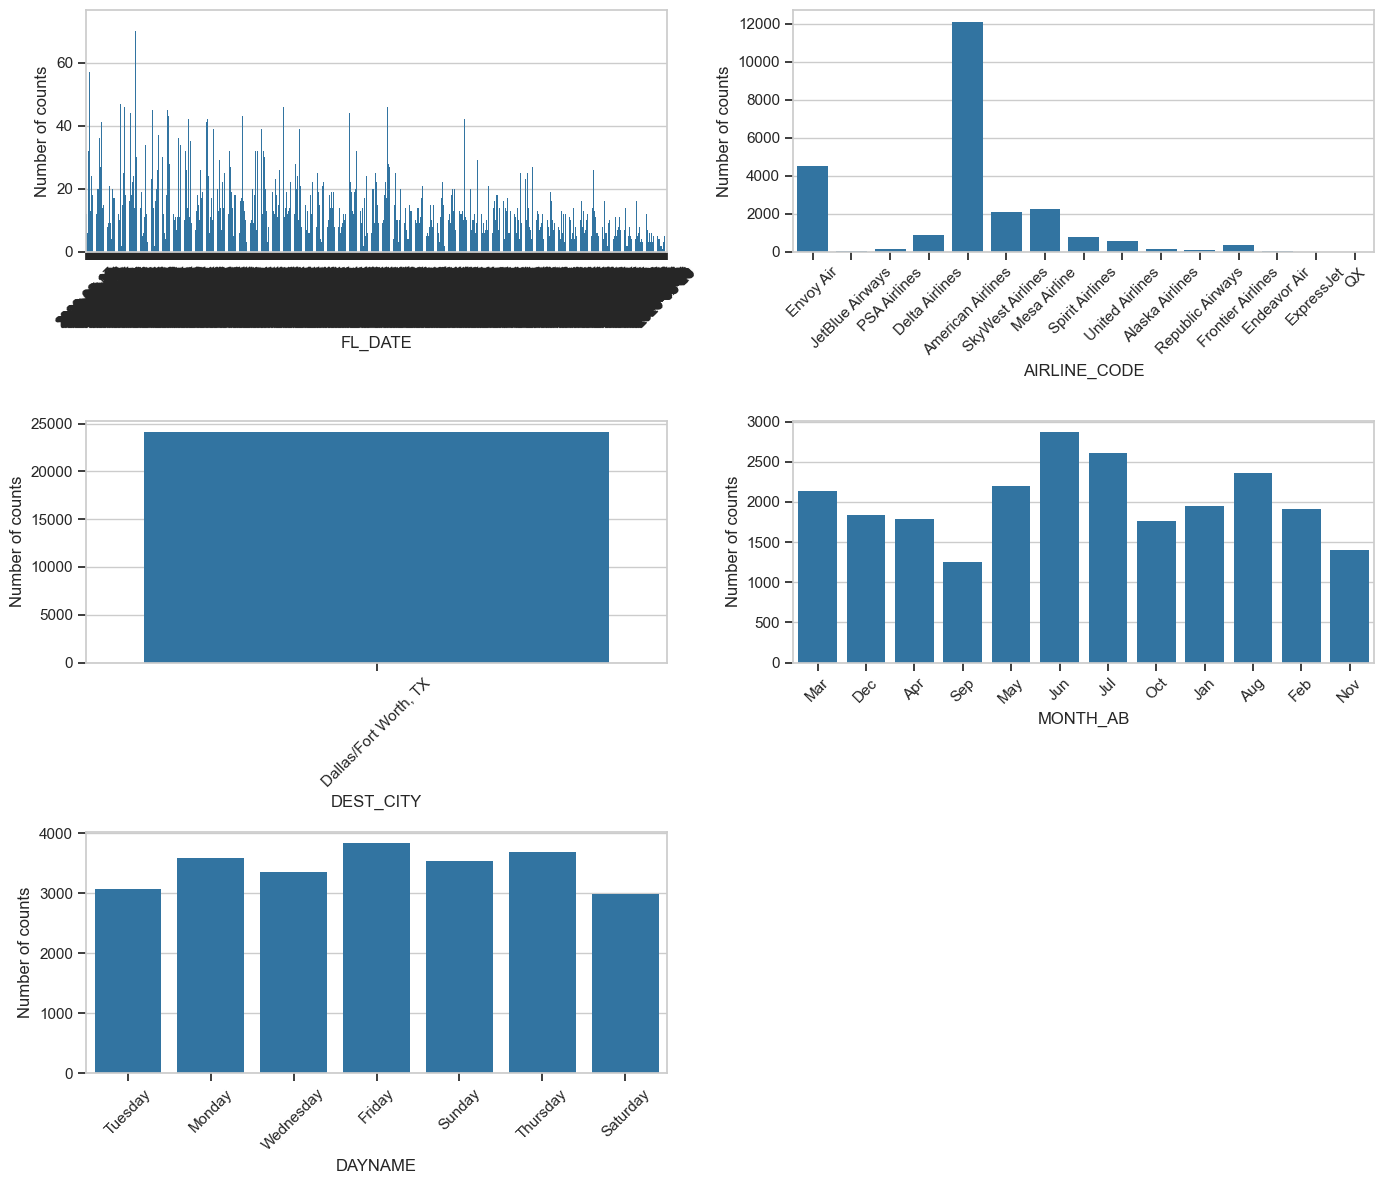

In [48]:
category = [i for i in flight_category if i not in ["ORIGIN", "DEST", "OP_CARRIER", "FLIGHT_STATUS"]]

# Output Barplot showing the occurrence of each categorical feature
n_features = len(category)
ncols = 2
nrows = (n_features + 1) // ncols

fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(14, nrows * 4))
plt.subplots_adjust(hspace=0.5, wspace=0.5)
sns.set_palette("husl", 8)
sns.set_context("notebook")

for i, feature in enumerate(category):
    row = i // ncols
    col = i % ncols
    ax[row, col] = sns.countplot(x=feature, data=flight_category, ax=ax[row, col])
    ax[row, col].set_ylabel("Number of counts")
    ax[row, col].tick_params(axis='x', rotation=45)

# Hide unused subplots if n_features is odd
if n_features % ncols != 0:
    fig.delaxes(ax[row, col+1])

plt.tight_layout()
plt.show()


Classification Modelling
Data Preparation
Encoding
Feature Selection
one hot encoding method in which one dummy variable would be created for every object in the categorical variable. If the particular object is present, the value would be denoted as 1, otherwise the value would be 0.

In [49]:
Carrier = pd.get_dummies(flight_data['AIRLINE_CODE'],prefix="AIRLINE_CODE",drop_first=False)
#Destination = pd.get_dummies(flight_data['DEST'],drop_first=False)
#Destination.columns = ['Charlotte_Airport','Chicago_Airport','Dallas_Airpot','Denver_Airport','Dentroit_Airport','GELL_Airpot','George_Aiport','Hartsfield_Airport','JohnFKeenedy_Airpot','LaGuardia_Airport','LosAngelas_Airport','McCarran_Airport','MSP_Airport','NL_Airport','Orlando_Airport','Philadelphia_Airport','Phoenix_Airport','Ronald_Airport','SanFrancisco_Airport','Seattle_Aiport']                  
month= pd.get_dummies(flight_data['MONTH_AB'],prefix="MONTH",drop_first=False)
day= pd.get_dummies(flight_data['DAYNAME'],prefix="DAY",drop_first=False)

#flight_data_new=pd.concat([flight_data,Carrier,Destination,month,day],axis=1)
flight_data_new=pd.concat([flight_data,Carrier,month,day],axis=1)

In [50]:
flight_data_new.head(2)

,FL_DATE,AIRLINE_CODE,ORIGIN,DEST,DEST_CITY,DEP_DELAY,TAXI_OUT,TAXI_IN,ARR_DELAY,DIVERTED,CRS_ELAPSED_TIME,ELAPSED_TIME,AIR_TIME,DISTANCE,DELAY_DUE_CARRIER,DELAY_DUE_WEATHER,DELAY_DUE_NAS,DELAY_DUE_SECURITY,DELAY_DUE_LATE_AIRCRAFT,DAY,MONTH,MONTH_AB,DAYOFWEEK,DAYNAME,WEEKDAY,FLIGHT_STATUS,AIRLINE_CODE_Alaska Airlines,AIRLINE_CODE_American Airlines,AIRLINE_CODE_Delta Airlines,AIRLINE_CODE_Endeavor Air,AIRLINE_CODE_Envoy Air,AIRLINE_CODE_ExpressJet,AIRLINE_CODE_Frontier Airlines,AIRLINE_CODE_JetBlue Airways,AIRLINE_CODE_Mesa Airline,AIRLINE_CODE_PSA Airlines,AIRLINE_CODE_QX,AIRLINE_CODE_Republic Airways,AIRLINE_CODE_SkyWest Airlines,AIRLINE_CODE_Spirit Airlines,AIRLINE_CODE_United Airlines,MONTH_Apr,MONTH_Aug,MONTH_Dec,MONTH_Feb,MONTH_Jan,MONTH_Jul,MONTH_Jun,MONTH_Mar,MONTH_May,MONTH_Nov,MONTH_Oct,MONTH_Sep,DAY_Friday,DAY_Monday,DAY_Saturday,DAY_Sunday,DAY_Thursday,DAY_Tuesday,DAY_Wednesday
79,2020-03-17,Envoy Air,Killeen-Fort Hood Regional Airport,Dallas/Fort Worth International Airport,"Dallas/Fort Worth, TX",52.0,32.0,20.0,85.0,0.0,59.0,92.0,40.0,134.0,0.0,0.0,33.0,0.0,52.0,17,3,Mar,1,Tuesday,1,1,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,True,False
389,2022-12-19,JetBlue Airways,Gen. Edward Lawrence Logan International Airport,Dallas/Fort Worth International Airport,"Dallas/Fort Worth, TX",26.0,18.0,10.0,26.0,0.0,274.0,274.0,246.0,1562.0,22.0,0.0,0.0,0.0,4.0,19,12,Dec,0,Monday,1,1,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False


In [64]:
columns_to_drop2 = [
    'FL_DATE', 'AIRLINE_CODE', 'ORIGIN', 'DEST', 'DEST_CITY', 'DAYOFWEEK',
    'MONTH', 'MONTH_AB', 'DAY', 'DAYNAME', 'WEEKDAY', 'ARR_DELAY',
    'DELAY_DUE_CARRIER', 'DELAY_DUE_WEATHER', 'DELAY_DUE_NAS',
    'DELAY_DUE_SECURITY', 'DELAY_DUE_LATE_AIRCRAFT'
]

existing_columns_to_drop = [col for col in columns_to_drop2 if col in flight_data_new.columns]
flight_data_new.drop(existing_columns_to_drop, axis=1, inplace=True)
print(flight_data_new.head(10))


      DEP_DELAY  TAXI_OUT  TAXI_IN  CRS_ELAPSED_TIME  ELAPSED_TIME  AIR_TIME  \
79         52.0      32.0     20.0              59.0          92.0      40.0   
389        26.0      18.0     10.0             274.0         274.0     246.0   
575        24.0      19.0     11.0              63.0         102.0      72.0   
598        43.0      10.0      9.0             118.0         108.0      89.0   
610        35.0      25.0      6.0             143.0         158.0     127.0   
643        93.0      18.0     42.0             245.0         263.0     203.0   
684        87.0       8.0      8.0             111.0          92.0      76.0   
1201       -1.0      71.0     14.0             240.0         300.0     215.0   
1309       12.0      17.0      7.0             176.0         187.0     163.0   
1446        1.0      77.0      7.0             123.0         190.0     106.0   

      DISTANCE  FLIGHT_STATUS  AIRLINE_CODE_Alaska Airlines  \
79       134.0              1                         Fa

In [65]:
flight_data_new.info()

<class 'pandas.core.frame.DataFrame'>
Index: 24081 entries, 79 to 2999982
Data columns (total 42 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   DEP_DELAY                       24081 non-null  float64
 1   TAXI_OUT                        24081 non-null  float64
 2   TAXI_IN                         24081 non-null  float64
 3   CRS_ELAPSED_TIME                24081 non-null  float64
 4   ELAPSED_TIME                    24081 non-null  float64
 5   AIR_TIME                        24081 non-null  float64
 6   DISTANCE                        24081 non-null  float64
 7   FLIGHT_STATUS                   24081 non-null  int64  
 8   AIRLINE_CODE_Alaska Airlines    24081 non-null  bool   
 9   AIRLINE_CODE_American Airlines  24081 non-null  bool   
 10  AIRLINE_CODE_Delta Airlines     24081 non-null  bool   
 11  AIRLINE_CODE_Endeavor Air       24081 non-null  bool   
 12  AIRLINE_CODE_Envoy Air          24

In [54]:
from sklearn.model_selection import train_test_split
from feature_engine.selection import DropConstantFeatures

In [66]:
X_train, X_test, y_train, y_test = train_test_split(
    flight_data_new.drop(labels=['FLIGHT_STATUS'], axis=1),
    flight_data_new['FLIGHT_STATUS'],
    test_size=0.2,
    random_state=100)

X_train.shape, X_test.shape

((19264, 41), (4817, 41))

In [67]:
sel = DropConstantFeatures(tol=1, variables=None, missing_values='raise')
sel.fit(X_train)

DropConstantFeatures()

In [68]:
len(sel.features_to_drop_)

0

In [69]:
sel.features_to_drop_

[]

In [60]:
X_train = sel.transform(X_train)
X_test = sel.transform(X_test)

X_train.shape, X_test.shape

((19264, 56), (4817, 56))

In [71]:
print(flight_data_new.head(10))


      DEP_DELAY  TAXI_OUT  TAXI_IN  CRS_ELAPSED_TIME  ELAPSED_TIME  AIR_TIME  \
79         52.0      32.0     20.0              59.0          92.0      40.0   
389        26.0      18.0     10.0             274.0         274.0     246.0   
575        24.0      19.0     11.0              63.0         102.0      72.0   
598        43.0      10.0      9.0             118.0         108.0      89.0   
610        35.0      25.0      6.0             143.0         158.0     127.0   
643        93.0      18.0     42.0             245.0         263.0     203.0   
684        87.0       8.0      8.0             111.0          92.0      76.0   
1201       -1.0      71.0     14.0             240.0         300.0     215.0   
1309       12.0      17.0      7.0             176.0         187.0     163.0   
1446        1.0      77.0      7.0             123.0         190.0     106.0   

      DISTANCE  FLIGHT_STATUS  AIRLINE_CODE_Alaska Airlines  \
79       134.0              1                         Fa

In [72]:
corrmat = X_train.corr()
corrmat = corrmat.abs().unstack() # absolute value of corr coef
corrmat = corrmat.sort_values(ascending=False)
corrmat = corrmat[corrmat >= 0.8]
corrmat = corrmat[corrmat < 1]
corrmat = pd.DataFrame(corrmat).reset_index()
corrmat.columns = ['feature1', 'feature2', 'corr']

In [74]:
corrmat

,feature1,feature2,corr
0,DISTANCE,CRS_ELAPSED_TIME,0.971470
1,CRS_ELAPSED_TIME,DISTANCE,0.971470
2,AIR_TIME,CRS_ELAPSED_TIME,0.965572
3,CRS_ELAPSED_TIME,AIR_TIME,0.965572
4,AIR_TIME,ELAPSED_TIME,0.955867
5,ELAPSED_TIME,AIR_TIME,0.955867
6,DISTANCE,AIR_TIME,0.946049
7,AIR_TIME,DISTANCE,0.946049
8,ELAPSED_TIME,CRS_ELAPSED_TIME,0.926516
9,CRS_ELAPSED_TIME,ELAPSED_TIME,0.926516


In [75]:
corrmat.feature1.unique()

array(['DISTANCE', 'CRS_ELAPSED_TIME', 'AIR_TIME', 'ELAPSED_TIME'],
      dtype=object)

In [76]:
grouped_feature_ls = []
correlated_groups = []

for feature in corrmat.feature1.unique():
    
    if feature not in grouped_feature_ls:

        # find all features correlated to a single feature
        correlated_block = corrmat[corrmat.feature1 == feature]
        grouped_feature_ls = grouped_feature_ls + list(
            correlated_block.feature2.unique()) + [feature]

        # append the block of features to the list
        correlated_groups.append(correlated_block)

print('found {} correlated groups'.format(len(correlated_groups)))
print('out of {} total features'.format(X_train.shape[1]))

found 1 correlated groups
out of 41 total features


In [77]:
for group in correlated_groups:
    print(group)
    print()

    feature1          feature2      corr
0   DISTANCE  CRS_ELAPSED_TIME  0.971470
6   DISTANCE          AIR_TIME  0.946049
11  DISTANCE      ELAPSED_TIME  0.898005



In [78]:
group = correlated_groups[0]
group


,feature1,feature2,corr
0,DISTANCE,CRS_ELAPSED_TIME,0.971470
6,DISTANCE,AIR_TIME,0.946049
11,DISTANCE,ELAPSED_TIME,0.898005


In [79]:
from sklearn.ensemble import RandomForestClassifier

# add all features of the group to a list
features = list(group['feature2'].unique())+['CRS_ELAPSED_TIME']

# train a random forest 
rf = RandomForestClassifier(n_estimators=100, random_state=100, max_depth=4)
rf.fit(X_train[features].fillna(0), y_train)

RandomForestClassifier(max_depth=4, random_state=100)

In [80]:
# get the feature importance attributed by the 
# random forest model (more on this in coming lectures)

importance = pd.concat(
    [pd.Series(features),
     pd.Series(rf.feature_importances_)], axis=1)

importance.columns = ['feature', 'importance']

# sort features by importance, most important first
importance.sort_values(by='importance', ascending=False)

,feature,importance
2,ELAPSED_TIME,0.358251
1,AIR_TIME,0.265564
3,CRS_ELAPSED_TIME,0.190930
0,CRS_ELAPSED_TIME,0.185255


In [81]:
# Drop the redundant columns 
flight_data_new.drop(['CRS_ELAPSED_TIME','AIR_TIME'], axis = 1, inplace = True)

**Remove multicollinearity effect (Negative)**

In [82]:
corrmat = X_train.corr()
corrmat = corrmat.abs().unstack() # absolute value of corr coef
corrmat = corrmat.sort_values(ascending=False)
corrmat = corrmat[corrmat <= -0.8]
corrmat = corrmat[corrmat > -1]
corrmat = pd.DataFrame(corrmat).reset_index()
corrmat.columns = ['feature1', 'feature2', 'corr']

In [83]:
grouped_feature_ls = []
correlated_groups = []

for feature in corrmat.feature1.unique():
    
    if feature not in grouped_feature_ls:

        # find all features correlated to a single feature
        correlated_block = corrmat[corrmat.feature1 == feature]
        grouped_feature_ls = grouped_feature_ls + list(
            correlated_block.feature2.unique()) + [feature]

        # append the block of features to the list
        correlated_groups.append(correlated_block)

print('found {} correlated groups'.format(len(correlated_groups)))
print('out of {} total features'.format(X_train.shape[1]))

found 0 correlated groups
out of 41 total features


**Importance by Random Forest**

In [84]:
X_train, X_test, y_train, y_test = train_test_split(
    flight_data_new.drop(labels=['FLIGHT_STATUS'], axis=1),
    flight_data_new['FLIGHT_STATUS'],
    test_size=0.2,
    random_state=100)

X_train.shape, X_test.shape

((19264, 39), (4817, 39))

In [85]:
rf = RandomForestClassifier(n_estimators=100, random_state=100, max_depth=5)
rf.fit(X_train, y_train)
rf.feature_importances_


array([0.55745566, 0.08476979, 0.05935216, 0.07716589, 0.05277159,
       0.00146767, 0.0038737 , 0.00282065, 0.00229607, 0.0100254 ,
       0.        , 0.00359202, 0.00377418, 0.00305404, 0.00662221,
       0.        , 0.00567685, 0.00459555, 0.00206476, 0.00432361,
       0.00609666, 0.00848908, 0.00640378, 0.00464926, 0.00356284,
       0.00210207, 0.00243695, 0.00580348, 0.00466981, 0.0141627 ,
       0.00599531, 0.00604625, 0.0035721 , 0.00413952, 0.00891198,
       0.00667718, 0.00648835, 0.0102605 , 0.00383038])

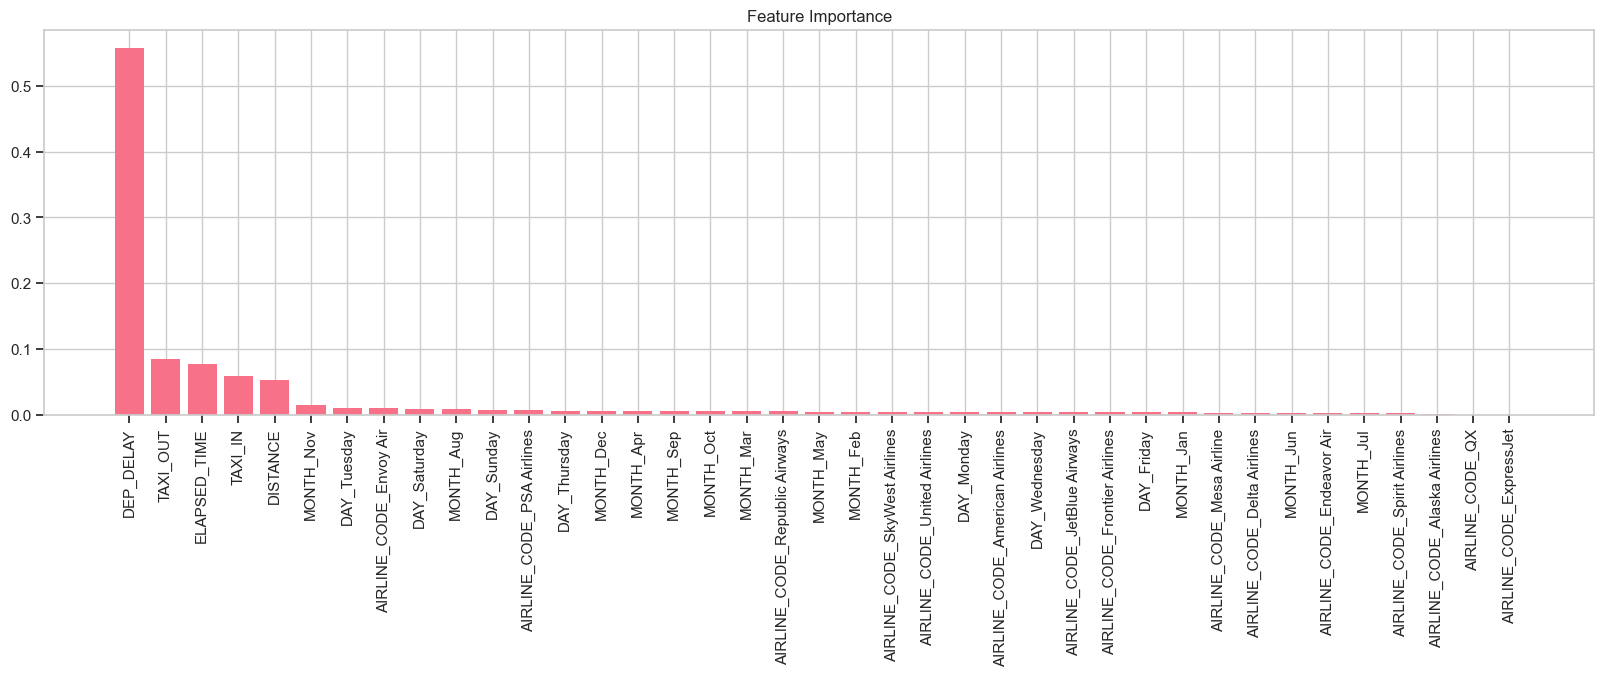

In [86]:
# Sorting in descending order and rearranging feature names to match sorted feature importance
importance = rf.feature_importances_
indices = np.argsort(importance)[::-1] 
names = [X_train.columns[i] for i in indices]

# Bar chart creation
sns.set_context("notebook")
plt.figure(figsize=(20, 5))
plt.title("Feature Importance")
plt.bar(range(X_train.shape[1]), importance[indices])
plt.xticks(range(X_train.shape[1]), names, rotation = 90)

plt.show()

In [87]:
features=pd.DataFrame(names)
scale = pd.DataFrame(importance[indices])
keep_features = pd.concat([features, scale],axis=1)
keep_features


,0,0
0,DEP_DELAY,0.557456
1,TAXI_OUT,0.084770
2,ELAPSED_TIME,0.077166
3,TAXI_IN,0.059352
4,DISTANCE,0.052772
5,MONTH_Nov,0.014163
6,DAY_Tuesday,0.010261
7,AIRLINE_CODE_Envoy Air,0.010025
8,DAY_Saturday,0.008912
9,MONTH_Aug,0.008489


**Classification Modelling**

In [92]:
from sklearn.metrics import (
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score, 
    accuracy_score, 
    confusion_matrix, 
    classification_report, 
    ConfusionMatrixDisplay,
    precision_recall_curve
)

**Base classifiers**
1. Logistic regression
2. SVM
3. Decision Tree
4. Random Forest

In [93]:
flight_data_new.info()


<class 'pandas.core.frame.DataFrame'>
Index: 24081 entries, 79 to 2999982
Data columns (total 40 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   DEP_DELAY                       24081 non-null  float64
 1   TAXI_OUT                        24081 non-null  float64
 2   TAXI_IN                         24081 non-null  float64
 3   ELAPSED_TIME                    24081 non-null  float64
 4   DISTANCE                        24081 non-null  float64
 5   FLIGHT_STATUS                   24081 non-null  int64  
 6   AIRLINE_CODE_Alaska Airlines    24081 non-null  bool   
 7   AIRLINE_CODE_American Airlines  24081 non-null  bool   
 8   AIRLINE_CODE_Delta Airlines     24081 non-null  bool   
 9   AIRLINE_CODE_Endeavor Air       24081 non-null  bool   
 10  AIRLINE_CODE_Envoy Air          24081 non-null  bool   
 11  AIRLINE_CODE_ExpressJet         24081 non-null  bool   
 12  AIRLINE_CODE_Frontier Airlines  24

In [94]:
flight_data_new["FLIGHT_STATUS"] = flight_data_new["FLIGHT_STATUS"].astype('category')

In [95]:
flight_data_new.info()


<class 'pandas.core.frame.DataFrame'>
Index: 24081 entries, 79 to 2999982
Data columns (total 40 columns):
 #   Column                          Non-Null Count  Dtype   
---  ------                          --------------  -----   
 0   DEP_DELAY                       24081 non-null  float64 
 1   TAXI_OUT                        24081 non-null  float64 
 2   TAXI_IN                         24081 non-null  float64 
 3   ELAPSED_TIME                    24081 non-null  float64 
 4   DISTANCE                        24081 non-null  float64 
 5   FLIGHT_STATUS                   24081 non-null  category
 6   AIRLINE_CODE_Alaska Airlines    24081 non-null  bool    
 7   AIRLINE_CODE_American Airlines  24081 non-null  bool    
 8   AIRLINE_CODE_Delta Airlines     24081 non-null  bool    
 9   AIRLINE_CODE_Endeavor Air       24081 non-null  bool    
 10  AIRLINE_CODE_Envoy Air          24081 non-null  bool    
 11  AIRLINE_CODE_ExpressJet         24081 non-null  bool    
 12  AIRLINE_CODE_Frontie

In [96]:
flight_data_new.to_csv('flight_data_new.csv',index=False)

In [97]:
X_train, X_test, y_train, y_test = train_test_split(
    flight_data_new.drop(labels=['FLIGHT_STATUS'], axis=1),
    flight_data_new['FLIGHT_STATUS'],
    test_size=0.2,
    random_state=100)

X_train.shape, X_test.shape

((19264, 39), (4817, 39))

**Random forest**

In [98]:
def run_randomForests(X_train, X_test, y_train, y_test):
    rf = RandomForestClassifier(n_estimators=100, random_state=100, max_depth=4)
    rf.fit(X_train, y_train)

    print('Test set')
    pred = rf.predict_proba(X_test)
    print('Roc-auc Random Forests roc-auc: {}'.format(roc_auc_score(y_test, pred[:,1])))
    print()
    print('Accuracy Random Forest test:', accuracy_score(y_test, rf.predict(X_test)))
    print()
    print('Precision Random Forest test:', precision_score(y_test, rf.predict(X_test),pos_label=1))
    print()
    print('Recall Random Forest test:', recall_score(y_test, rf.predict(X_test),pos_label=1))
    print()
    print('F-measure Random Forest test:', f1_score(y_test, rf.predict(X_test),pos_label=1))
    print()
    print('Summary Report:')
    print(classification_report(y_test, rf.predict(X_test)))

In [99]:
run_randomForests(X_train, X_test, y_train, y_test)

Test set
Roc-auc Random Forests roc-auc: 0.8045928479103834

Accuracy Random Forest test: 0.963670334232925

Precision Random Forest test: 0.963670334232925

Recall Random Forest test: 1.0

F-measure Random Forest test: 0.9814991013849245

Summary Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       175
           1       0.96      1.00      0.98      4642

    accuracy                           0.96      4817
   macro avg       0.48      0.50      0.49      4817
weighted avg       0.93      0.96      0.95      4817



**Logistic Regression**

In [100]:
from sklearn.linear_model import LogisticRegression

In [101]:
def run_logisticReg(X_train, X_test, y_train, y_test):
    lr = LogisticRegression(random_state=100)
    lr.fit(X_train, y_train)

    print('Test set')
    pred = lr.predict_proba(X_test)
    print('Roc-auc Logistic Regression roc-auc: {}'.format(roc_auc_score(y_test, pred[:,1])))
    print()
    print('Accuracy Logistic Regression:', accuracy_score(y_test, lr.predict(X_test)))
    print()
    print('Precision Logistic Regression:', precision_score(y_test, lr.predict(X_test),pos_label=1))
    print()
    print('Recall Logistic Regression:', recall_score(y_test, lr.predict(X_test),pos_label=1))
    print()
    print('F-measure Logistic Regression:', f1_score(y_test, lr.predict(X_test),pos_label=1))
    print()
    print('Summary Report:')
    print(classification_report(y_test, lr.predict(X_test)))

In [102]:
run_logisticReg(X_train, X_test, y_train, y_test)

Test set
Roc-auc Logistic Regression roc-auc: 0.8655998030405614

Accuracy Logistic Regression: 0.9634627361428275

Precision Logistic Regression: 0.963855421686747

Recall Logistic Regression: 0.999569151227919

F-measure Logistic Regression: 0.9813874788494078

Summary Report:
              precision    recall  f1-score   support

           0       0.33      0.01      0.01       175
           1       0.96      1.00      0.98      4642

    accuracy                           0.96      4817
   macro avg       0.65      0.50      0.50      4817
weighted avg       0.94      0.96      0.95      4817



**Decision Tree**

In [103]:
from sklearn.tree import DecisionTreeClassifier

In [105]:
def run_DT(X_train, X_test, y_train, y_test):
    DT = DecisionTreeClassifier(random_state=100)
    DT = DT.fit(X_train,y_train)

    print('Test set')
    pred = DT.predict_proba(X_test)
    print('Roc-auc Decision Tree roc-auc: {}'.format(roc_auc_score(y_test, pred[:,1])))
    print()
    print('Accuracy Decision Tree:', accuracy_score(y_test, DT.predict(X_test)))
    print()
    print('Precision Decision Tree:', precision_score(y_test, DT.predict(X_test),pos_label=1))
    print()
    print('Recall Decision Tree:', recall_score(y_test, DT.predict(X_test),pos_label=1))
    print()
    print('F-measure Decision Tree:', f1_score(y_test, DT.predict(X_test),pos_label=1))
    print()
    print('Summary Report:')
    print(classification_report(y_test, DT.predict(X_test)))


In [106]:
run_DT(X_train, X_test, y_train, y_test)

Test set
Roc-auc Decision Tree roc-auc: 0.5610426540284361

Accuracy Decision Tree: 0.9329458168984845

Precision Decision Tree: 0.9681335356600911

Recall Decision Tree: 0.9620853080568721

F-measure Decision Tree: 0.9650999459751486

Summary Report:
              precision    recall  f1-score   support

           0       0.14      0.16      0.15       175
           1       0.97      0.96      0.97      4642

    accuracy                           0.93      4817
   macro avg       0.55      0.56      0.56      4817
weighted avg       0.94      0.93      0.94      4817



**Support Vector Machine(SVM)**

In [107]:
from sklearn import svm

In [112]:
def run_SVM(X_train, X_test, y_train, y_test):
    svm_class = svm.SVC(probability=True, random_state=100)
    svm_class.fit(X_train, y_train)

    print('Test set')
    pred_proba = svm_class.predict_proba(X_test)[:, 1]  # Probabilities of the positive class
    print('ROC-AUC Score: {:.4f}'.format(roc_auc_score(y_test, pred_proba)))
    print()
    
    y_pred = svm_class.predict(X_test)
    print('Accuracy: {:.4f}'.format(accuracy_score(y_test, y_pred)))
    print()
    
    print('Precision: {:.4f}'.format(precision_score(y_test, y_pred, pos_label=1)))
    print()
    
    print('Recall: {:.4f}'.format(recall_score(y_test, y_pred, pos_label=1)))
    print()
    
    print('F-measure: {:.4f}'.format(f1_score(y_test, y_pred, pos_label=1)))
    print()


In [113]:
run_SVM(X_train, X_test, y_train, y_test)

Test set
ROC-AUC Score: 0.6018

Accuracy: 0.9637

Precision: 0.9637

Recall: 1.0000

F-measure: 0.9815



**CalibratedSVM**

In [120]:
from sklearn.calibration import CalibratedClassifierCV
from sklearn.svm import SVC

In [121]:
def run_CSVM(X_train, X_test, y_train, y_test):
    svm = SVC()
    clf = CalibratedClassifierCV(svm)
    clf.fit(X_train, y_train)

    print('Test set')
    pred = clf.predict_proba(X_test)
    print('Roc-auc SVM Option 2 roc-auc: {:.4f}'.format(roc_auc_score(y_test, pred[:,1])))
    print()
    print('Accuracy SVM Option 2: {:.4f}'.format(accuracy_score(y_test, clf.predict(X_test))))
    print()
    print('Precision SVM Option 2: {:.4f}'.format(precision_score(y_test, clf.predict(X_test), pos_label=1)))
    print()
    print('Recall SVM Option 2: {:.4f}'.format(recall_score(y_test, clf.predict(X_test), pos_label=1)))
    print()
    print('F-measure SVM Option 2: {:.4f}'.format(f1_score(y_test, clf.predict(X_test), pos_label=1)))
    print()
    print('Summary Report:')
    print(classification_report(y_test, clf.predict(X_test)))

In [122]:
run_CSVM(X_train, X_test, y_train, y_test)

Test set
Roc-auc SVM Option 2 roc-auc: 0.7980

Accuracy SVM Option 2: 0.9637

Precision SVM Option 2: 0.9637

Recall SVM Option 2: 1.0000

F-measure SVM Option 2: 0.9815

Summary Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       175
           1       0.96      1.00      0.98      4642

    accuracy                           0.96      4817
   macro avg       0.48      0.50      0.49      4817
weighted avg       0.93      0.96      0.95      4817



**Undersampling**
1. Logistic Regression
2. SVM
3. Decision Tree
4. Random Forest

In [124]:
from collections import Counter

import pandas as pd
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

from imblearn.datasets import fetch_datasets

from imblearn.under_sampling import (
    RandomUnderSampler,
    TomekLinks
)

In [137]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report, precision_recall_curve
import matplotlib.pyplot as plt
from sklearn.calibration import CalibratedClassifierCV
from sklearn.svm import SVC

def run_all(X_train, X_test, y_train, y_test):

    # Logistic regression
    lr = LogisticRegression(random_state=100)
    lr.fit(X_train, y_train)
    
    print('Logistic regression')
    pred = lr.predict_proba(X_test)
    print('Roc-auc Logistic Regression roc-auc: {:.4f}'.format(roc_auc_score(y_test, pred[:,1])))
    print()
    print('Accuracy Logistic Regression test: {:.4f}'.format(accuracy_score(y_test, lr.predict(X_test))))
    print()
    print('Precision Logistic Regression test: {:.4f}'.format(precision_score(y_test, lr.predict(X_test), pos_label=1)))
    print()
    print('Recall Logistic Regression test: {:.4f}'.format(recall_score(y_test, lr.predict(X_test), pos_label=1)))
    print()
    print('F-measure Logistic Regression test: {:.4f}'.format(f1_score(y_test, lr.predict(X_test), pos_label=1)))
    print()
    print('Summary Report:')
    print(classification_report(y_test, lr.predict(X_test)))
    
    # Decision Tree
    DT = DecisionTreeClassifier(random_state=100)
    DT.fit(X_train, y_train)
    
    print('Decision Tree')
    pred = DT.predict_proba(X_test)
    print('Roc-auc Decision Tree roc-auc: {:.4f}'.format(roc_auc_score(y_test, pred[:,1])))
    print()
    print('Accuracy Decision Tree test: {:.4f}'.format(accuracy_score(y_test, DT.predict(X_test))))
    print()
    print('Precision Decision Tree test: {:.4f}'.format(precision_score(y_test, DT.predict(X_test), pos_label=1)))
    print()
    print('Recall Decision Tree test: {:.4f}'.format(recall_score(y_test, DT.predict(X_test), pos_label=1)))
    print()
    print('F-measure Decision Tree test: {:.4f}'.format(f1_score(y_test, DT.predict(X_test), pos_label=1)))
    print()
    print('Summary Report:')
    print(classification_report(y_test, DT.predict(X_test)))

    # Random Forest
    rf = RandomForestClassifier(n_estimators=100, random_state=100, max_depth=4)
    rf.fit(X_train, y_train)
    
    print('Random Forest')
    pred = rf.predict_proba(X_test)
    print('Roc-auc Random Forests roc-auc: {:.4f}'.format(roc_auc_score(y_test, pred[:,1])))
    print()
    print('Accuracy Random Forest test: {:.4f}'.format(accuracy_score(y_test, rf.predict(X_test))))
    print()
    print('Precision Random Forest test: {:.4f}'.format(precision_score(y_test, rf.predict(X_test), pos_label=1)))
    print()
    print('Recall Random Forest test: {:.4f}'.format(recall_score(y_test, rf.predict(X_test), pos_label=1)))
    print()
    print('F-measure Random Forest test: {:.4f}'.format(f1_score(y_test, rf.predict(X_test), pos_label=1)))
    print()
    print('Summary Report:')
    print(classification_report(y_test, rf.predict(X_test)))
    
    # Precision Recall Curve
    print()
    print('Precision Recall Curve')
    ax = plt.gca()
    precision, recall, _ = precision_recall_curve(y_test, lr.predict_proba(X_test)[:,1])
    plt.plot(recall, precision, label='Logistic Regression')
    
    precision, recall, _ = precision_recall_curve(y_test, DT.predict_proba(X_test)[:,1])
    plt.plot(recall, precision, label='Decision Tree')
    
    precision, recall, _ = precision_recall_curve(y_test, rf.predict_proba(X_test)[:,1])
    plt.plot(recall, precision, label='Random Forest')
    
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend()
    plt.show()

# Example usage:
# Assuming you have X_train, X_test, y_train, y_test defined somewhere
# run_all(X_train, X_test, y_train, y_test)


In [138]:
undersampler_dict = {

    'random': RandomUnderSampler(
        sampling_strategy='auto',
        random_state=100,
        replacement=False)
}

In [139]:
datasets_ls = ['flight_data_new']

Full data
Logistic regression
Roc-auc Logistic Regression roc-auc: 0.8656

Accuracy Logistic Regression test: 0.9635

Precision Logistic Regression test: 0.9639

Recall Logistic Regression test: 0.9996

F-measure Logistic Regression test: 0.9814

Summary Report:
              precision    recall  f1-score   support

           0       0.33      0.01      0.01       175
           1       0.96      1.00      0.98      4642

    accuracy                           0.96      4817
   macro avg       0.65      0.50      0.50      4817
weighted avg       0.94      0.96      0.95      4817

Decision Tree
Roc-auc Decision Tree roc-auc: 0.5610

Accuracy Decision Tree test: 0.9329

Precision Decision Tree test: 0.9681

Recall Decision Tree test: 0.9621

F-measure Decision Tree test: 0.9651

Summary Report:
              precision    recall  f1-score   support

           0       0.14      0.16      0.15       175
           1       0.97      0.96      0.97      4642

    accuracy                 

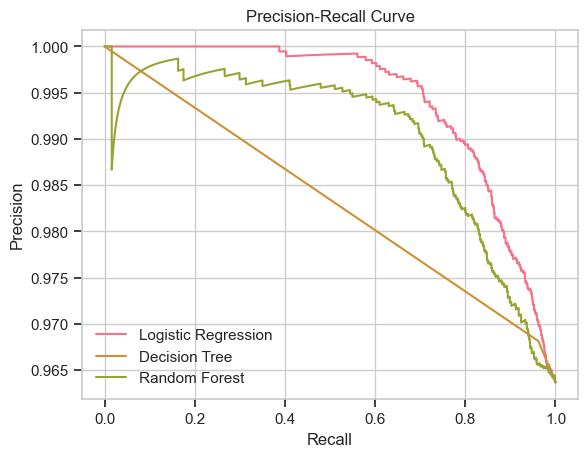


random
Logistic regression
Roc-auc Logistic Regression roc-auc: 0.8684

Accuracy Logistic Regression test: 0.7440

Precision Logistic Regression test: 0.9936

Recall Logistic Regression test: 0.7391

F-measure Logistic Regression test: 0.8477

Summary Report:
              precision    recall  f1-score   support

           0       0.11      0.87      0.20       175
           1       0.99      0.74      0.85      4642

    accuracy                           0.74      4817
   macro avg       0.55      0.81      0.52      4817
weighted avg       0.96      0.74      0.82      4817

Decision Tree
Roc-auc Decision Tree roc-auc: 0.7162

Accuracy Decision Tree test: 0.7339

Precision Decision Tree test: 0.9847

Recall Decision Tree test: 0.7352

F-measure Decision Tree test: 0.8419

Summary Report:
              precision    recall  f1-score   support

           0       0.09      0.70      0.16       175
           1       0.98      0.74      0.84      4642

    accuracy                   

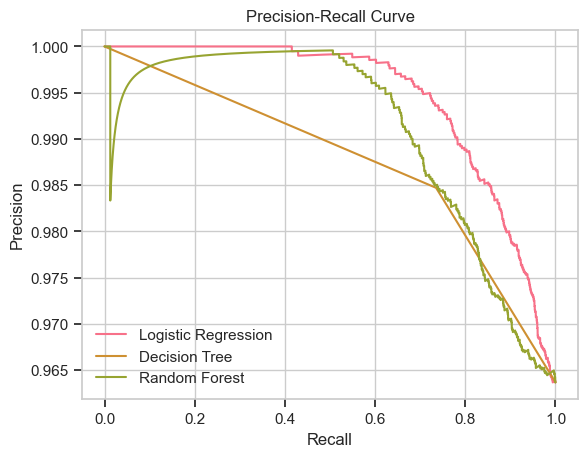

In [140]:
for dataset in datasets_ls:
    
    print('Full data')
        
    run_all(X_train, X_test, y_train, y_test)
    
    print()
    
    for undersampler in undersampler_dict.keys():
        
        print(undersampler)
        
        # resample
        X_resampled, y_resampled = undersampler_dict[undersampler].fit_resample(X_train, y_train)
        
        run_all(X_resampled, X_test, y_resampled, y_test)
        
        print()

**oversampling**

In [141]:
from imblearn.over_sampling import (
    RandomOverSampler
)

In [142]:
oversampler_dict = {

    'random': RandomOverSampler(
        sampling_strategy='auto',
        random_state=100)
}

flight_data_new
Logistic regression
Roc-auc Logistic Regression roc-auc: 0.8656

Accuracy Logistic Regression test: 0.9635

Precision Logistic Regression test: 0.9639

Recall Logistic Regression test: 0.9996

F-measure Logistic Regression test: 0.9814

Summary Report:
              precision    recall  f1-score   support

           0       0.33      0.01      0.01       175
           1       0.96      1.00      0.98      4642

    accuracy                           0.96      4817
   macro avg       0.65      0.50      0.50      4817
weighted avg       0.94      0.96      0.95      4817

Decision Tree
Roc-auc Decision Tree roc-auc: 0.5610

Accuracy Decision Tree test: 0.9329

Precision Decision Tree test: 0.9681

Recall Decision Tree test: 0.9621

F-measure Decision Tree test: 0.9651

Summary Report:
              precision    recall  f1-score   support

           0       0.14      0.16      0.15       175
           1       0.97      0.96      0.97      4642

    accuracy           

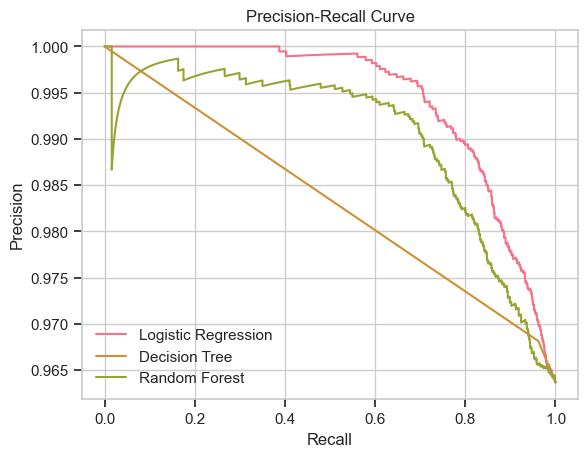


random
Status check: Done resampling
Logistic regression
Roc-auc Logistic Regression roc-auc: 0.8679

Accuracy Logistic Regression test: 0.7447

Precision Logistic Regression test: 0.9928

Recall Logistic Regression test: 0.7404

F-measure Logistic Regression test: 0.8482

Summary Report:
              precision    recall  f1-score   support

           0       0.11      0.86      0.20       175
           1       0.99      0.74      0.85      4642

    accuracy                           0.74      4817
   macro avg       0.55      0.80      0.52      4817
weighted avg       0.96      0.74      0.82      4817

Decision Tree
Roc-auc Decision Tree roc-auc: 0.5390

Accuracy Decision Tree test: 0.9381

Precision Decision Tree test: 0.9665

Recall Decision Tree test: 0.9694

F-measure Decision Tree test: 0.9680

Summary Report:
              precision    recall  f1-score   support

           0       0.12      0.11      0.11       175
           1       0.97      0.97      0.97      4642

 

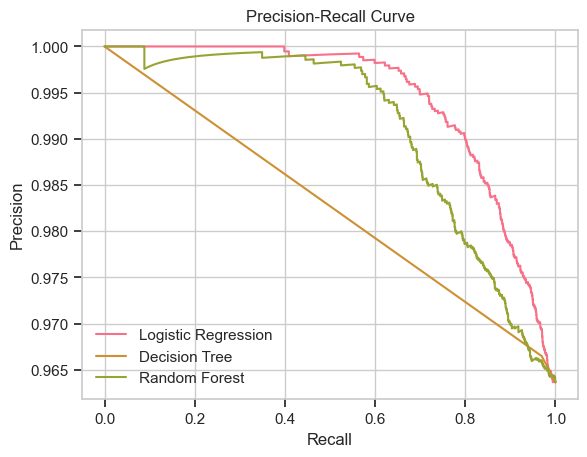

In [143]:
for dataset in datasets_ls:
    
    print(dataset)
    
    run_all(X_train, X_test, y_train, y_test)
    
    print()
    
    for oversampler in oversampler_dict.keys():
        
        print(oversampler)
        
        # resample
        X_resampled, y_resampled = oversampler_dict[oversampler].fit_resample(X_train, y_train)
        
        print("Status check: Done resampling")
        # evaluate performance
        run_all(X_resampled, X_test, y_resampled, y_test)
        print()
        
    print()